# 关键词搜索进阶版

 除了显而易见的自制feature之外，讨论更加牛的算法：
    
    *String Distance
    *TF_iDF
    *Word2vec

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

In [2]:
df_train = pd.read_csv('train.csv', encoding='ISO-8859-1')
df_test = pd.read_csv('test.csv', encoding='ISO-8859-1')
df_desc = pd.read_csv('product_descriptions.csv')

In [3]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [4]:
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')

## step2:文本处理

In [5]:
stemmer = SnowballStemmer('english')
#词形归一
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [6]:
def str_common_word(str1, str2):
    #str1 是搜索词 str2 是产品词
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [7]:
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))

In [8]:
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

In [9]:
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

## Step 3: 进阶版文本特征

Levenshtein
使用Levenshtein很直观，直接调用python标准库

In [10]:
import Levenshtein
#文本距离,0.625次变换从左变到右
Levenshtein.ratio('hello', 'hello world')

0.625

In [11]:
 df_all['dist_in_title'] = df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_title']), axis=1)

同理对产品介绍进行比较

In [12]:
df_all['dist_in_desc'] = df_all.apply(lambda x:Levenshtein.ratio(x['search_term'],x['product_description']), axis=1)

## TF-iDF

稍复杂，因为涉及到一个需要提前把所以文本计算统计一下的过程

首先搞一个新的column，叫all_texts，里面是所有的texts。不算search term 因为不算一个完整的句子，会影响tfidf学习。为了防止句子格式不完整，强制加上句号

注意，最严谨的做法是把train 、test先分开，然后只在train上做tfidf学习，并在test上直接转化。

In [13]:
df_all['all_texts'] = df_all['product_title'] + '.' + df_all['product_description'] + '.'

In [14]:
df_all['all_texts'][:5]

0    simpson strong-ti 12-gaug angl.not onli do ang...
1    simpson strong-ti 12-gaug angl.not onli do ang...
2    behr premium textur deckov 1-gal. #sc-141 tugb...
3    delta vero 1-handl shower onli faucet trim kit...
4    delta vero 1-handl shower onli faucet trim kit...
Name: all_texts, dtype: object

然后取出所有的单字，做成一个我们的单词字典：这里用gensim为了更加细致的分解tfidf的步骤动作；其实sklearn本身也有简单好用的tfidf模型详见第二课stock news 基本版教材

Tokenize可以用各家或者各种方法，就是把长长的string变成list of tokens 包括NLTK，SKLEARN都有自家的解决方案。或者自己直接用str自带的split（）方法，也是一种tokenize。只要记住，在这里用什么之后文本处理就得用什么

三步走：
    
    1.建立语料库

In [15]:
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(list(tokenize(x, errors='ignore')) for x in df_all['all_texts'].values)
print(dictionary)
#字典，统计unique的token

Dictionary(221877 unique tokens: ['odorsmay', 'installationdelux', 'windhigh', 'lifecentr', 'ratchetteardrop']...)


得到一个大词典，我们以此准备出一个语料库。因为语料库都很大，所以做预料的时候都用个iterator来实现

写一个类，扫遍我们所有的预料，并且转化成简单的单词个数计算(Bag-of-Words)

In [16]:
#把由字符表示的东西转化成由数字表示
class MyCorpus(object):
    def __iter__(self):
        for x in df_all['all_texts'].values:
            yield dictionary.doc2bow(list(tokenize(x, errors='ignore')))
#这里是为了内存friendly。面对daliangcorpus数据时直接存成一个list，会使得整个运行变得很慢。
#所以，一次只输出一组，但本质上依旧长得跟[['sentence', '1'],['sentence', '2'], ....]一样

corpus = MyCorpus()

有了标准形式的语料库，就可以init我们的TFIDFmodel

这里把已经变成Bow向量的数组，做一次TFIDF的计算

In [17]:
from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus)
#上步，相同的词变成相同的数字，处理方便

In [18]:
tfidf[dictionary.doc2bow(list(tokenize('hello world, good morning', errors='ignore')))]

[(965, 0.2947139124944075),
 (3427, 0.28760732706613895),
 (33768, 0.6587176730120703),
 (35248, 0.6296957697663794)]

怎么判断两个句子的相似度呢

这里有个trick，因为我们得到的tfidf只是‘有这个字就有这个值’，并不是一个全部值

也就是说，两个matrix可能size是完全不一样的

想用cosine计算两个matri的size都不fix怎么办

实际上他们的size是一样的，只是把全部是0的那部分省略了

只要拿其中一个作为index，扩展全部的matrixsize，另一个带入就可以计算了


！直观上不等长，计算的时候补全0，等长！

In [20]:
from gensim.similarities import MatrixSimilarity
#先把刚刚那句话包装成一个方法
def to_tfidf(text):
    res = tfidf[dictionary.doc2bow(list(tokenize(text, errors='ignore')))]
    return res
#然后创造一个cosine similarity的比较方法
def cos_sim(text1, text2):
    tfidf1 = to_tfidf(text1)
    tfidf2 = to_tfidf(text2)
    index = MatrixSimilarity([tfidf1],num_features=len(dictionary))
    sim = index[tfidf2]
    #本来sim输出是一个array，我们不需要一个array来表示，
    #所以直接cast成一个float
    return float(sim[0])


In [21]:
#测试
text1 = 'hello world'
text2 = 'hello from the other side'
cos_sim(text1, text2)

0.8566456437110901

现在只需要把我妈的column都转化成tfidf计算出来的相似度了

因为sim的结果是一个 np array 所以我们用'[0]'取里面那个唯一值就行

In [22]:
df_all['tfidf_cos_sim_in_title'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_title']), axis=1)

In [23]:
df_all['tfidf_cos_sim_in_title'][:5]

0    0.274539
1    0.000000
2    0.000000
3    0.133577
4    0.397320
Name: tfidf_cos_sim_in_title, dtype: float64

In [24]:
df_all['tfidf_cos_sim_in_desc'] = df_all.apply(lambda x: cos_sim(x['search_term'], x['product_description']), axis=1)

至此，有了两个高质量的features

## Word2Vec

最好的情况是，在另一个地方用非常大非常完备的语料库做好w2v的training，再跑到这个任务上来直接输出vector。

可以参照谷歌新闻语料的大w2v模型，可下载供以后使用#迁移学习

这里用轻量级的解决方案，直接在我们的文本上学习

w2v和tfidf有个很大的不同。对于tfidf而言，只需知道一整段text中包含了哪些word元素就行了，其他不用管

但是w2v要考虑到句子层级的split，以及语境前后的考虑

所以，刚才tfidf的corpus不能直接在这里使用。这里需要把句子/文字都分类好

In [25]:
import nltk
# nltk也是自带的一个强大的句子分割器
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [26]:
tokenizer.tokenize(df_all['all_texts'].values[0])

['simpson strong-ti 12-gaug angl.not onli do angl make joint stronger, they also provid more consistent, straight corners.',
 'simpson strong-ti offer a wide varieti of angl in various size and thick to handl light-duti job or project where a structur connect is needed.',
 'some can be bent (skewed) to match the project.',
 'for outdoor project or those where moistur is present, use our zmax zinc-coat connectors, which provid extra resist against corros (look for a "z" at the end of the model number).versatil connector for various 90 connect and home repair projectsstrong than angl nail or screw fasten alonehelp ensur joint are consist straight and strongdimensions: 3 in.',
 'x 3 in.',
 'x 1-1/2 in.mad from 12-gaug steelgalvan for extra corros resistanceinstal with 10d common nail or #9 x 1-1/2 in.',
 'strong-driv sd screw.']

依照这个方法，先把长文搞成list of 句子，再把句子变成list of 单词

In [27]:
sentences = [tokenizer.tokenize(x) for x in df_all['all_texts'].values]

这些sectences不需要这些层级关系，他们都是平级的，所以，我们把list of lists 给 flatten

In [28]:
sentences = [y for x in sentences for y in x]

In [29]:
len(sentences)

1743749

用nltk的word_tokenizer 分单词

In [30]:
from nltk.tokenize import word_tokenize
w2v_corpus = [word_tokenize(x) for x in sentences]

训练model

In [31]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(w2v_corpus, size=128, window=5, min_count=5, workers=4)

In [32]:
model['right']

array([  3.47967327e-01,  -8.54729533e-01,   2.04158831e+00,
         1.45377684e+00,  -2.65805030e+00,   4.47951365e+00,
        -7.55638838e-01,  -1.44326591e+00,  -1.28745092e-02,
         2.62550235e+00,   1.85847771e+00,   2.05359483e+00,
        -3.20908636e-01,  -6.95929766e-01,  -4.61395174e-01,
        -2.01288676e+00,  -3.40045857e+00,  -1.86195362e+00,
         2.12801576e+00,   1.04790473e+00,   7.22504199e-01,
         1.50738931e+00,  -5.12790680e-01,   4.22909451e+00,
         2.74110866e+00,  -1.87516665e+00,   5.51511049e-01,
         1.64419401e+00,  -8.38544130e-01,  -2.56294870e+00,
         2.65035772e+00,   1.13786340e+00,  -1.83872044e+00,
        -1.46582830e+00,  -3.18576872e-01,   2.84865355e+00,
        -2.50486779e+00,   4.49710274e+00,   4.27818775e+00,
         1.99319795e-01,  -3.64105392e+00,  -1.53855073e+00,
        -6.43496811e-01,  -7.03367651e-01,  -1.95507479e+00,
        -5.57853746e+00,  -3.42616653e+00,  -3.55552912e+00,
         1.54249144e+00,

TFiDF是针对每个句子都可以有的，而w2v是针对每个单词的

综合考虑， 平均化一个句子的w2v向量，算作整个text的平均vector

In [33]:
# 先拿到全部的vocabulary
vocab = model.wv.vocab
#得到任意text的vector
def get_vector(text):
    #建立一个全是0的array
    res = np.zeros([128])
    count = 0
    for word in word_tokenize(text):
        if word in vocab:
            res += model[word]
            count +=1
    return res/count

In [34]:
print(get_vector('life is like a box of chocolate'))

[-0.56815962 -0.79064775  0.01629514  0.48889474 -0.06818936 -1.19077753
  1.78009207 -1.31022909  0.13018069  1.12343802  1.7691134   1.72980344
  0.73520495 -2.00703351 -0.4635177   1.48538567  0.53312059  0.74684211
  0.68697607  0.05655934 -1.2026065   0.20172774 -0.30561496  0.6435056
  0.06736407 -0.0515124  -0.8579278   0.87366803 -2.04154217 -2.31723779
  0.45330219 -0.67340626 -0.13482145  0.1779775   0.89294825 -0.81390373
  0.88093318  1.05884123  0.42206439 -0.62250475 -0.01461942  0.29446978
 -0.71506147 -1.10059198 -1.14220005 -0.16998334  0.58612288 -0.49382464
 -0.91879163  0.51390662  0.6867155  -0.53714868 -1.03897902 -0.86439122
  1.24123174  0.30775407  0.14510699  0.20363941 -0.4812558  -0.2346594
 -0.39492076  0.08578583  0.75494603  0.10585962  0.47294712 -1.49090493
 -0.7180107   0.00392697 -2.79357188 -0.15272    -0.48103975  1.65806722
 -0.18784409 -0.04435756  0.05529203  0.52813169 -2.28983665  0.28309548
 -0.46243469 -0.15967963  0.52565318 -3.32596455  0.7

计算两个text的平均w2v的cosine similarity

In [35]:
from scipy import spatial
# 用scipy的spatial
def w2v_cos_sim(text1, text2):
    try:
        w2v1 = get_vector(text1)
        w2v2 = get_vector(text2)
        sim = 1 - spatial.distance.cosine(w2v1, w2v2)
        return float(sim)
    except:
        return float(0)
#防止得到的vector是[0,0,0....]

In [36]:
w2v_cos_sim('hello world', 'hello from the other side')

0.24436244756719694

In [37]:
df_all['w2v_cos_sim_in_title'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_title']), axis=1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [38]:
df_all['w2v_cos_sim_in_desc'] = df_all.apply(lambda x: w2v_cos_sim(x['search_term'], x['product_description']), axis=1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


KeyboardInterrupt: 

In [39]:
df_all.head(5)

,id,product_title,product_uid,relevance,search_term,product_description,dist_in_title,dist_in_desc,all_texts,tfidf_cos_sim_in_title,tfidf_cos_sim_in_desc,w2v_cos_sim_in_title
0,2,simpson strong-ti 12-gaug angl,100001,3.00,angl bracket,"not onli do angl make joint stronger, they als...",0.190476,0.030418,simpson strong-ti 12-gaug angl.not onli do ang...,0.274539,0.182836,0.458738
1,3,simpson strong-ti 12-gaug angl,100001,2.50,l bracket,"not onli do angl make joint stronger, they als...",0.153846,0.022901,simpson strong-ti 12-gaug angl.not onli do ang...,0.000000,0.000000,0.307401
2,9,behr premium textur deckov 1-gal. #sc-141 tugb...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,0.175000,0.017875,behr premium textur deckov 1-gal. #sc-141 tugb...,0.000000,0.053455,0.318033
3,16,delta vero 1-handl shower onli faucet trim kit...,100005,2.33,rain shower head,updat your bathroom with the delta vero single...,0.326087,0.048632,delta vero 1-handl shower onli faucet trim kit...,0.133577,0.043712,0.556359
4,17,delta vero 1-handl shower onli faucet trim kit...,100005,2.67,shower onli faucet,updat your bathroom with the delta vero single...,0.382979,0.054545,delta vero 1-handl shower onli faucet trim kit...,0.397320,0.098485,0.725689


In [40]:
df_all = df_all.drop(['search_term','product_title','product_description','all_texts'],axis=1)

## step4  重塑训练、测试集

In [41]:
df_train = df_all.loc[df_train.index]
df_test = df_all.loc[df_test.index]
test_ids = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

## step 5 建立模型

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [43]:
params = [1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

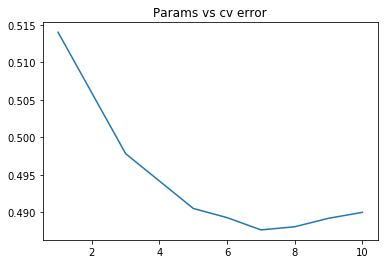

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Params vs cv error")

## step 6 上传结果

In [45]:
rf = RandomForestRegressor(n_estimators=30, max_depth=6)

In [46]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('submission1.csv',index=False)

可升级的部分：

1.更多的特征。Deep Learing的大重点就是黑盒机制。所以，其实我们刚得到的tfidf或者w2v vector可以就不做任何处理塞进我们的X里面去。然后我们使用更加深度的学习模型来训练它。
这样，我们的算法可以看见更加原始的信息。假设他们比人脑好的话，就可以做出更好的prediction

2.更好的回归模型。使用Ensemble，把分类器提升到极致